In [1]:
import os
import numpy as np
import torch
from torchsummary import summary
import copy
import matplotlib.pyplot as plt

import scipy.io.wavfile
import cupy as cp
import cusignal

from IPython.display import Audio

In [2]:
class data_from_dir(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_dir, resample=False):
        'Initialization'
        self.resample = resample
        self.file_dir = file_dir
        self.file_filenames = [ x for x in os.listdir(file_dir) ]
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_filenames)

    def __getitem__(self, index, resample=False):
        'Load one sample of data'
        # Select sample
        sr, wave = scipy.io.wavfile.read(os.path.join(self.file_dir, self.file_filenames[index]))
        if self.resample:
            # Let's resample and scale:
            target_length = 5 # seconds
            target_sr = 48000 # sampling rate, samples per second
            wave_gpu = cp.asarray(wave)
            resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
            resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
            scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
            return scaled_wave.reshape(1, -1) # each element in array is one-dimensional, so need to reshape as 1-dimensional array
        else:
            return wave.reshape(1, -1)
            

In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [4]:
%%time
# dataset = data_from_dir("../data/dataset/resampled", resample=False) # load already prepared and resampled files
# dataset = data_from_dir("../data/dataset/25G_train", resample=False) # load already prepared and resampled files
dataset = data_from_dir("../../data/dataset/small", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(dataset))

# # check all files to be consistent before pass to neural network
# for index, wave in enumerate(dataset):
#     if len(wave[0]) != 240000:
#         print("Size error:     ", dataset.file_filenames[index])
#         print("Current length: ", len(dataset[index]))
#         break
# if index+1 == len(dataset):
#     print("All files consistent and have same length 240k amplitudes each")
# print()
# print()

# wave

Dataset size:  2000
CPU times: user 0 ns, sys: 2.32 ms, total: 2.32 ms
Wall time: 1.57 ms


In [5]:
%%time
# now split whole dataset to train and test subsets
# get 50% for tests

train_size = int(0.5 * len(dataset))
# train_size = int(0.961 * len(dataset))
# train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Train dataset size: ", len(train_dataset))
print("Test dataset size:  ", len(test_dataset))
print()

Train dataset size:  1000
Test dataset size:   1000

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.41 ms


In [6]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) #, num_workers=4) # num_workers have an issue, not working
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True) #, num_workers=4)

CPU times: user 132 µs, sys: 0 ns, total: 132 µs
Wall time: 137 µs


In [7]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [8]:
# describe model architecture

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        kernel_size_1 = int(64) # 128, stride=2, pool=2
        padding_1 = int((kernel_size_1 - 1)/2) # 
        # ReLU = 0.0056
        # ReLU6 = 0.0055
        # LeakyReLU(0.1) = 0.0053
        # Hardtanh = 0.0072
        # PReLU = 0.0055
        # RReLU = 0.0055
        # SELU = 0.0067
        
        self.activation = torch.nn.LeakyReLU(0.1)

        self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=16, padding=padding_1)
        self.enc1bn = torch.nn.BatchNorm1d(32)
        self.enc1ac = self.activation

        self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=16, padding=padding_1-7)
        self.dec1bn = torch.nn.BatchNorm1d(1)
        self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
        # now initialize weights
        torch.nn.init.kaiming_uniform_(self.enc1co.weight)
        torch.nn.init.kaiming_uniform_(self.dec1uco.weight)

    def forward(self, x):
        x = self.enc1co(x)
        x = self.enc1bn(x)
        x = self.enc1ac(x)
        
        x = self.dec1uco(x)
        x = self.dec1bn(x)
        x = self.dec1ac(x)
        return x


In [9]:
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working
summary(model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 15000]           2,080
       BatchNorm1d-2            [-1, 32, 15000]              64
         LeakyReLU-3            [-1, 32, 15000]               0
   ConvTranspose1d-4            [-1, 1, 240000]           2,049
       BatchNorm1d-5            [-1, 1, 240000]               2
           Sigmoid-6            [-1, 1, 240000]               0
Total params: 4,195
Trainable params: 4,195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.92
Forward/backward pass size (MB): 16.48
Params size (MB): 0.02
Estimated Total Size (MB): 17.41
----------------------------------------------------------------


In [10]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = (criterion(outputs, inputs))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.detach() * inputs.size(0)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)           
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
        liveloss.update(logs)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
    print("\nTrained.")

In [11]:
torch.cuda.empty_cache()
model = ConvAutoencoder()
criterion = torch.nn.MSELoss()
# criterion = FocalLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005) # [0.001 .. 0.0005 ... 0.0001] 0.001 per 10 epochs & 0.00001 per 1000 epochs

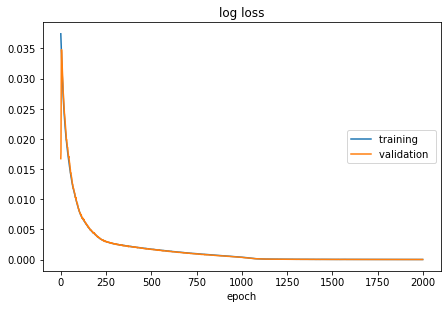

log loss
	training         	 (min:    0.000, max:    0.037, cur:    0.000)
	validation       	 (min:    0.000, max:    0.035, cur:    0.000)

[2000/2000]    {'log loss': 2.1424475562525913e-05, 'val_log loss': 1.5616000382578932e-05}

Trained.
CPU times: user 3h 26min 2s, sys: 1h 22min 27s, total: 4h 48min 29s
Wall time: 1h 12min 45s


In [12]:
%%time
train_model(model, criterion, optimizer, num_epochs=2000) # start @ 10:35:30

In [22]:
%%time
validation_dataset = data_from_dir("../../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

# check one file in dataset to be sure everything is good:
file_number=50
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)

Dataset size:  524
Type:               <class 'numpy.ndarray'>
Data:               [3529 3529 3454 ... 2553 2778 3179]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -27860
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 119 ms, sys: 422 µs, total: 119 ms
Wall time: 126 ms


In [23]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
outputs = model(inputs)
loss = (criterion(outputs, inputs))
print(f"loss: {loss.item()}")
result = np.int16(((outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(result[0][0], rate=sr)

loss: 1.184056691272417e-05


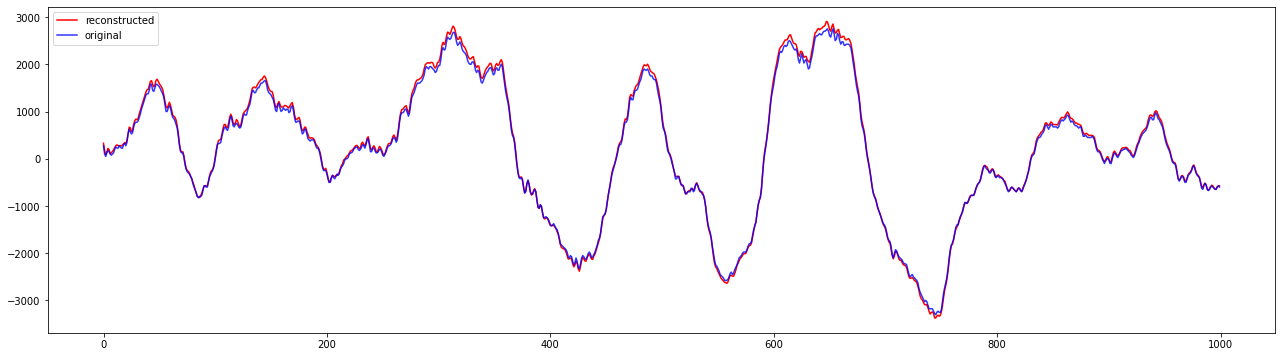

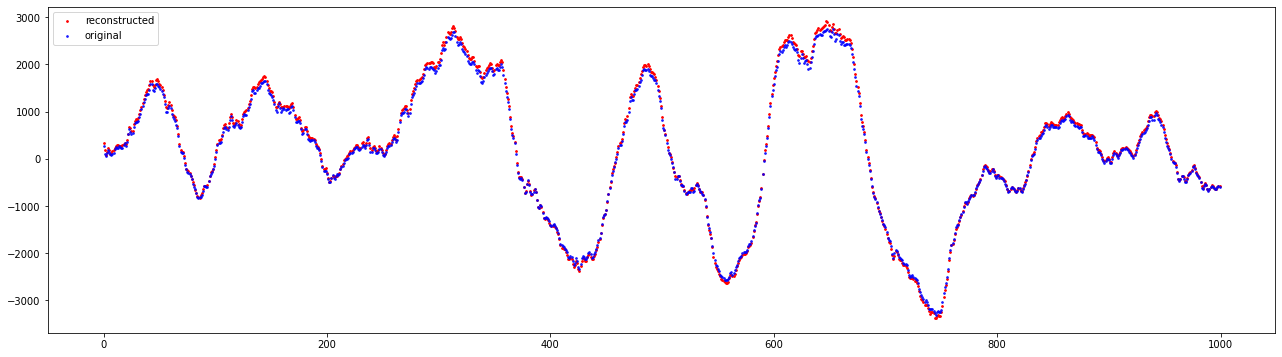

In [26]:
amp_start = 1000
amp_end =   2000
plt.figure(figsize=(22,6))
plt.plot(result[0][0][amp_start:amp_end], linestyle="-", color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.plot(wave[amp_start:amp_end], linestyle="-", color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, amp_end-amp_start)
plt.scatter(x, result[0][0][amp_start:amp_end], s=3, color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.scatter(x, wave[amp_start:amp_end], s=3, color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

In [18]:
model_path = "../../models/ConvAutoEncoder.l1.000-5.000-5.model.pt"
torch.save(model, model_path)
os.chown(model_path, 1000, 1000)